# Диалог с клоном

Идея проекта заключается в том, чтобы создать чать бот на данных реального диалога. Некое подобие клона образа человека, иммитирующего его общение в чате.

Реализация:
1. Сохраняем диалог из меседжера VK в виде текстовых файлов;
2. Извлекаем из полученного диалога вопросы к выбранному собеседнику и его ответы.
3. Преобразуем вопросы: очищаем, лемматизируем, векторизируем, сокращаем размерность векторов методом главных компонент, кластеризируем. В итоге получаем разметку вопросов по группам.
4. Обучаем модель классификации: в качестве признаков векторизированный текст, в качестве целевого признака полученные группы вопросов.
5. Запускаем чат бот. При получении текста очищаем, лемматизируем, векторизируем и подаём в обученный классификатор. Выбираем случайный ответ из группы, совпадающей с выданной классификатором.

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re

from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation

from telegram import Update, ForceReply
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackContext

In [2]:
# pip install pymorphy2

## Чтение данных

In [3]:
PATH = "d:/PycharmProjects/Chat_bot_Oleg/"

In [4]:
# Чтение файла и отправка данных в БД
def readfile():
    """Парсим данные из текстовых файлов с перепиской скачанной из VK
    """
    filename = ['Севастополь, поехали!/#0 30.05.2020_21.34 - 14.07.2020_18.07.txt',
                'Севастополь, поехали!/#1 14.07.2020_19.24 - 04.11.2020_18.38.txt',
                'Севастополь, поехали!/#2 04.11.2020_18.44 - 29.01.2021_21.09.txt',
                'Севастополь, поехали!/#3 29.01.2021_21.10 - 26.04.2021_11.39.txt',
                'Севастополь, поехали!/#4 26.04.2021_11.40 - 19.07.2021_19.35.txt',
                'Севастополь, поехали!/#5 19.07.2021_20.03 - 06.10.2021_10.09.txt',
                'Севастополь, поехали!/#6 06.10.2021_10.09 - 24.11.2021_18.47.txt',
                'Изюминская велофлудилка/#00 15.11.2018_10.46 - 22.01.2019_22.10.txt',
                'Изюминская велофлудилка/#01 22.01.2019_22.10 - 20.02.2019_18.37.txt',
                'Изюминская велофлудилка/#02 20.02.2019_18.52 - 25.03.2019_15.31.txt',
                'Изюминская велофлудилка/#03 25.03.2019_15.35 - 14.04.2019_19.37.txt',
                'Изюминская велофлудилка/#04 14.04.2019_19.39 - 06.05.2019_19.46.txt',
                'Изюминская велофлудилка/#05 06.05.2019_20.18 - 25.05.2019_19.27.txt',
                'Изюминская велофлудилка/#06 25.05.2019_19.40 - 07.06.2019_14.41.txt',
                'Изюминская велофлудилка/#07 07.06.2019_14.42 - 26.06.2019_18.14.txt',
                'Изюминская велофлудилка/#08 26.06.2019_18.16 - 27.08.2019_22.06.txt',
                'Изюминская велофлудилка/#09 27.08.2019_22.26 - 18.10.2019_11.22.txt',
                'Изюминская велофлудилка/#10 18.10.2019_12.22 - 06.12.2019_20.35.txt',
                'Изюминская велофлудилка/#11 06.12.2019_20.35 - 28.12.2019_20.20.txt',
                'Изюминская велофлудилка/#12 28.12.2019_20.22 - 16.01.2020_11.51.txt',
                'Изюминская велофлудилка/#13 16.01.2020_11.51 - 28.01.2020_13.25.txt',
                'Изюминская велофлудилка/#14 28.01.2020_13.26 - 12.02.2020_18.31.txt',
                'Изюминская велофлудилка/#15 12.02.2020_18.31 - 29.02.2020_22.39.txt',
                'Изюминская велофлудилка/#16 29.02.2020_22.50 - 19.03.2020_13.04.txt',
                'Изюминская велофлудилка/#17 19.03.2020_13.05 - 11.04.2020_14.13.txt',
                'Изюминская велофлудилка/#18 11.04.2020_15.27 - 04.05.2020_17.27.txt',
                'Изюминская велофлудилка/#19 04.05.2020_17.54 - 29.11.2020_11.44.txt'
               ]

    dialog = []
    for iFilename in filename:
        file = open(PATH+iFilename, encoding='utf8')
        lines = file.readlines()
        rangeFile = file.tell()
        file.seek(0)
        lenf = len(lines)
        previos = ''
        while file.tell() != rangeFile:
            line = file.readline()
            if (line != '\n')&(line[0] != '\t'):
                if 'tot_oleg' in line:
                    otvet = file.readline()
                    if otvet[0] == '\t':
                        vopros = file.readline()[1:]
                        trash = file.readline()
                        otvet = file.readline()
                    else:
                        vopros = previos
                    if (vopros[:-1] != '') & (otvet[:-1] != ''):
                        dialog.append([vopros[:-1], otvet[:-1]])
                else:
                    previos = file.readline()
                    while (previos[0] == '\t'):
                        previos = file.readline()
    print(len(dialog))
    return dialog

In [5]:
# Читаем данные из файлов
BOT_CONFIG = readfile()

2326


In [6]:
# Формируем вопросы(corpus) и ответы (y)
corpus = []
y = []
for intent in BOT_CONFIG:
    corpus.append(intent[0])
    y.append(intent[1])


In [7]:
df = pd.DataFrame()
df['text'] = corpus
len(corpus)

2326

In [27]:
corpus[:5]

['Да! С праздником Вас! Спортсмены!',
 'Олег, а ты не поехал?!',
 'Празднуете с семьёю?',
 'Олег, сколько там хамса стоит?',
 'Спасибо']

In [29]:
y[:5]

['С праздником!',
 'С утра не имею возможности - семейное планы. После обеда куда-нибудь куда успею съезжу.',
 'Ага, на рынке пятого километра 🤣',
 'Я ещё не там, если побываю на тех рядах, увижу - напишу.',
 'Хамса только на одной точке была в наличии']

**Вывод**

Данные прочитаны

## Преобразование данных

1. Очищаем и лемматизируем;
2. Векторизируем;
3. Сокращаем размерность векторов методом главных компонент, 
4. Кластеризируем. 

В итоге получаем разметку вопросов по группам

In [8]:
# Ускоритель лемматизатора
m = Mystem()
def checkExecTimeMystemOneText(texts):
    """ Лемматизация текста большими частями с разделением
    """
    lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
    txtpart = lol(texts, 1000)
    res = []
    for txtp in txtpart:
        alltexts = ' '.join([txt + ' br ' for txt in txtp])
        words = m.lemmatize(alltexts)
        doc = []
        for txt in words:
            if txt != '\n' and txt.strip() != '':
                if txt == 'br':
                    res.append(doc)
                    doc = []
                else:
                    doc.append(txt)
    return res

def lemm_text(text):
    """ очистка и лемматизация
    """
    return ' '.join([i for i in m.lemmatize(''.join(re.sub(r'[^а-яА-ЯёЁa-z]', ' ', text).lower())) if i != '\n'])

In [9]:
# Лематизация с очисткой
df['lemmatize'] = df['text'].apply(lambda x: ''.join(re.sub(r'[^а-яА-ЯёЁa-z]', ' ', x).lower()))
df.head()

df['lemmatize'] = checkExecTimeMystemOneText(df['lemmatize'])
df['lemmatize'] = df['lemmatize'].apply(' '.join)

In [10]:
df.head()

,text,lemmatize
0,Да! С праздником Вас! Спортсмены!,да с праздник вы спортсмен
1,"Олег, а ты не поехал?!",олег а ты не поехать
2,Празднуете с семьёю?,праздновать с семья
3,"Олег, сколько там хамса стоит?",олег сколько там хамса стоять
4,Спасибо,спасибо


In [11]:
# Читаем стоп-слова
stopwords = set(nltk_stopwords.words('russian'))

In [12]:
# Вектроизация вопросов
vectorizer = TfidfVectorizer(ngram_range=(2, 4), analyzer='char_wb', stop_words=stopwords)
vector_corpus = vectorizer.fit_transform(df['lemmatize'])

vector_corpus

<2326x16245 sparse matrix of type '<class 'numpy.float64'>'
	with 237165 stored elements in Compressed Sparse Row format>

In [13]:
# Уменьшение размерности векторов
n_class = 10
classes = ['class_'+str(i) for i in range(n_class)]
pca = PCA(n_components=n_class)
predict = pca.fit_transform(vector_corpus.toarray())

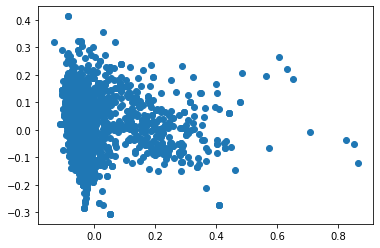

In [14]:
plt.scatter(predict[:,0], predict[:,1]);

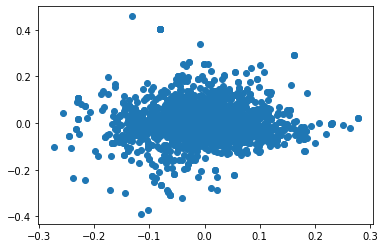

In [15]:
plt.scatter(predict[:,-1], predict[:,-2]);

In [16]:

df[classes] = predict
df['tot'] = y
# df.sort_values(by='class')[1000:1030]

In [17]:
df[classes].value_counts()

class_0    class_1    class_2    class_3    class_4    class_5    class_6    class_7    class_8    class_9  
-0.017313  -0.167495  -0.057799   0.032203   0.003289  -0.021747  -0.031879   0.016645   0.003929   0.004631    14
-0.036257  -0.200032   0.039737  -0.012656   0.055165  -0.038752   0.017647  -0.056383  -0.063471   0.125948     7
-0.017313  -0.167495  -0.057799   0.032203   0.003289  -0.021747  -0.031879   0.016645   0.003929   0.004631     6
-0.051142  -0.138113  -0.089177   0.094173   0.027425   0.035375  -0.163067  -0.195603   0.404101  -0.081390     6
-0.072551   0.131783   0.070471  -0.025987   0.037263   0.049019   0.066370  -0.132767   0.052296   0.110500     5
                                                                                                                ..
-0.044719  -0.026225  -0.055213  -0.010462  -0.034744  -0.007406   0.053159  -0.000019  -0.039475   0.044966     1
-0.044757   0.020187  -0.021839   0.011017   0.000847  -0.003935   0.030421  -0.021897

In [18]:
df.sort_values(by=classes).head()

,text,lemmatize,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,tot
556,"Мне кажется, что эти бравые велосипедисты не с...",я казаться что этот бравый велосипедист не сов...,-0.131669,0.319939,0.139393,-0.111539,-0.025991,0.124041,-0.043121,-0.015684,0.002952,-0.126097,👍
1747,"По старинке с орлиного будет быстрее, но на вк...",по старинка с орлиный быть быстро но на вкус и...,-0.111062,0.020529,0.115560,0.016120,0.162671,0.026075,0.078589,0.002081,-0.076874,0.010596,"Вполне возможно, но тут такое дело Денис, тут..."
1748,"По старинке с орлиного будет быстрее, но на вк...",по старинка с орлиный быть быстро но на вкус и...,-0.111062,0.020529,0.115560,0.016120,0.162671,0.026075,0.078589,0.002081,-0.076874,0.010596,К тому же в данном случае маршрут пролегает со...
395,Было дело,быть дело,-0.105185,0.022935,0.035014,0.209419,0.365782,0.194603,-0.050593,0.199755,0.091465,-0.047619,Посмотрите этот маршрут!
397,Было дело,быть дело,-0.105185,0.022935,0.035014,0.209419,0.365782,0.194603,-0.050593,0.199755,0.091465,-0.047619,"Ага, весело было встретить полицию у выезда на..."


In [19]:
%%time
# Кластеризация вопросов
clustering = AffinityPropagation(max_iter = 1000, random_state=5555)
clasters = clustering.fit_predict(df[classes])
clasters

CPU times: total: 18.6 s
Wall time: 18.6 s


array([ 97, 128,  41, ..., 123,  41,  41], dtype=int64)

In [20]:
df['claster'] = clasters

In [21]:
df['claster'].value_counts()

16     87
135    84
34     74
51     62
127    58
       ..
111     1
44      1
117     1
104     1
85      1
Name: claster, Length: 137, dtype: int64

In [30]:
df.sort_values(by='claster').head()

,text,lemmatize,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,tot,claster
2275,Вот спасибо!,вот спасибо,0.030022,-0.274092,-0.117051,-0.019536,-0.204742,0.496672,0.588620,0.045600,0.097670,-0.109372,Посмотрите этот маршрут! Вот такой получился э...,0
866,Спасибо,спасибо,0.054094,-0.305751,-0.177383,-0.015735,-0.193463,0.545257,0.653372,0.057853,0.070008,-0.134590,https://www.gpsies.com/map.do?fileId=lqlasjfhf...,0
865,Спасибо,спасибо,0.054094,-0.305751,-0.177383,-0.015735,-0.193463,0.545257,0.653372,0.057853,0.070008,-0.134590,Вот на завтра примерно так:,0
5,Спасибо,спасибо,0.054094,-0.305751,-0.177383,-0.015735,-0.193463,0.545257,0.653372,0.057853,0.070008,-0.134590,Без проблем,0
486,спасибо,спасибо,0.054094,-0.305751,-0.177383,-0.015735,-0.193463,0.545257,0.653372,0.057853,0.070008,-0.134590,Любители Велопрогулок и Велопоходов (*_*),0


**Вывод**

Данные преобразованы и готовы к обучению модели классификации.

## Обучение модели и запуск диалога

In [23]:
# Обучаем модель
clf = RandomForestClassifier(random_state=12345)
clf.fit(vector_corpus, df['claster'])

RandomForestClassifier(random_state=12345)

In [24]:
def start(update: Update, context: CallbackContext) -> None:
    """Send a message when the command /start is issued."""
    user = update.effective_user
    update.message.reply_markdown_v2(
        fr'Hi {user.mention_markdown_v2()}\!',
        reply_markup=ForceReply(selective=True),
    )


def help_command(update: Update, context: CallbackContext) -> None:
    """Send a message when the command /help is issued."""
    update.message.reply_text('Help!')


def echo(update: Update, context: CallbackContext) -> None:
    """Echo the user message."""
    input_text = update.message.text
    reply = bot(input_text)
    update.message.reply_text(reply)


def main() -> None:
    """Start the bot."""
    # Create the Updater and pass it your bot's token.
    updater = Updater("2136512388:AAFnKljrnlTUMoxEpGw1aRK0fGnhu-9lfS4")

    # Get the dispatcher to register handlers
    dispatcher = updater.dispatcher

    # on different commands - answer in Telegram
    dispatcher.add_handler(CommandHandler("start", start))
    dispatcher.add_handler(CommandHandler("help", help_command))

    # on non command i.e message - echo the message on Telegram
    dispatcher.add_handler(MessageHandler(Filters.text & ~Filters.command, echo))

    # Start the Bot
    updater.start_polling()

    updater.idle()

def get_intent_by_model(text):
    n_intent = clf.predict(vectorizer.transform([text]))[0]
    intent = df[df['claster'] == n_intent]['tot'].values
    return intent[random.randint(0, len(intent)-1)]

def bot(text):
    intent = get_intent_by_model(text)
    return intent

In [25]:
if __name__ == '__main__':
    main()

# Вывод

Заработало!

## Вывод по проекту

Цель проекта достигнута. Из живого диалога, мы извлекли данные и научили модель машинного обучения отвечать на вопросы фразами человека.
Конечто идеала достичь не удалось. Следующим шагом будет применение к исходному тексту не векторизации tf-idf, а преобразования с помощью модели Bert. Также, в дальнейшем надо будет изменить способ выбора ответвета внутри кластера со случайного на чтото более интелектуальное.